# Model-Evaluation & Project Wrap-Up  
*Comparing the Three Optimised ARIMA Specifications for Maryland Inflation*

This notebook serves as the final stage of our forecasting project.  
Here we **load, estimate, and benchmark** the three ARIMA models that
achieved the best information-criteria scores during the selection phase:

| Model ID | Specification | Rationale for Inclusion |
|----------|---------------|-------------------------|
| **M1**   | ARIMA(1, 0, 3) | Lowest AIC when no differencing was required (stationary at 5 % level) |
| **M2**   | ARIMA(4, 1, 1) | Best candidate after removing the unit root at 1 % significance |
| **M3**   | ARIMA(2, 1, 3) | Grid-search winner once ARIMA(1, 1, 4) failed the stability test |

The script performs four targeted tasks:

1. **Reload the cleaned time-series** and recreate the training / validation split.  
2. **Graphically examine the residuals** of each ARIMA ­– ACF/PACF of errors to confirm white-noise behaviour.  
3. **Produce one-year dynamic forecasts** and compute headline accuracy statistics – **R², MSE, and MAE** – for an apples-to-apples comparison.  
4. **Benchmark against the best LSTM model**, plotting both forecast paths side-by-side and tabulating the same metrics so classical and deep-learning approaches can be evaluated on identical ground.

The notebook concludes with a **brief discussion** outlining:

- Which ARIMA delivers the lowest forecast error for Maryland inflation.  
- Strengths and limitations of classical ARIMA relative to the LSTM approach developed earlier.  
- Recommendations for practitioners: model re-calibration frequency, incorporating exogenous drivers, and scenarios where the neural model may outperform.

With this evaluation complete, we close the project having delivered both
traditional and deep-learning pipelines, transparent diagnostics, and a
clear ranking of models for future inflation forecasting tasks.


In [22]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Data set

In [2]:

Resultados=pd.read_excel("C:\Users\alejo\OneDrive\Escritorio\Universidaad\6 Semestre\Econometria\GitHub Repository\ARIMA Forecasting and Errors.xlsx", header= 0)
Resultados

,state,year,quarter,pi,Trimestres,time,time_variable,Arima103,arima411,arima213,arm103pronsostico,arm411pronsostico,arm213pronsostico
0,Maryland,1978.0,1.0,-2.901486,1978q1,1978-01-01,1978-01-01,-5.585231,NaN,NaN,2.683746,NaN,NaN
1,Maryland,1978.0,2.0,-2.389739,1978q2,1978-04-01,1978-04-01,-0.024484,0.490646,0.478921,-2.365255,-2.880385,-2.868660
2,Maryland,1978.0,3.0,-0.422940,1978q3,1978-07-01,1978-07-01,1.081658,1.812301,1.792058,-1.504598,-2.235241,-2.214998
3,Maryland,1978.0,4.0,1.742279,1978q4,1978-10-01,1978-10-01,0.899931,1.617875,1.568790,0.842348,0.124404,0.173489
4,Maryland,1979.0,1.0,3.577910,1979q1,1979-01-01,1979-01-01,0.579094,1.142773,1.086007,2.998816,2.435137,2.491904
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,Maryland,2017.0,4.0,1.605726,2017q4,2017-10-01,2015-10-01,0.278604,0.279508,0.248191,1.327123,1.326218,1.357535
152,NaN,NaN,NaN,NaN,NaN,2018-01-01,2016-01-01,NaN,NaN,NaN,1.978420,1.451015,1.910691
153,NaN,NaN,NaN,NaN,NaN,2018-04-01,2016-04-01,NaN,NaN,NaN,1.888399,1.328358,1.371236
154,NaN,NaN,NaN,NaN,NaN,2018-07-01,2016-07-01,NaN,NaN,NaN,2.166901,1.837852,1.411759


## Graph White noises of the models 

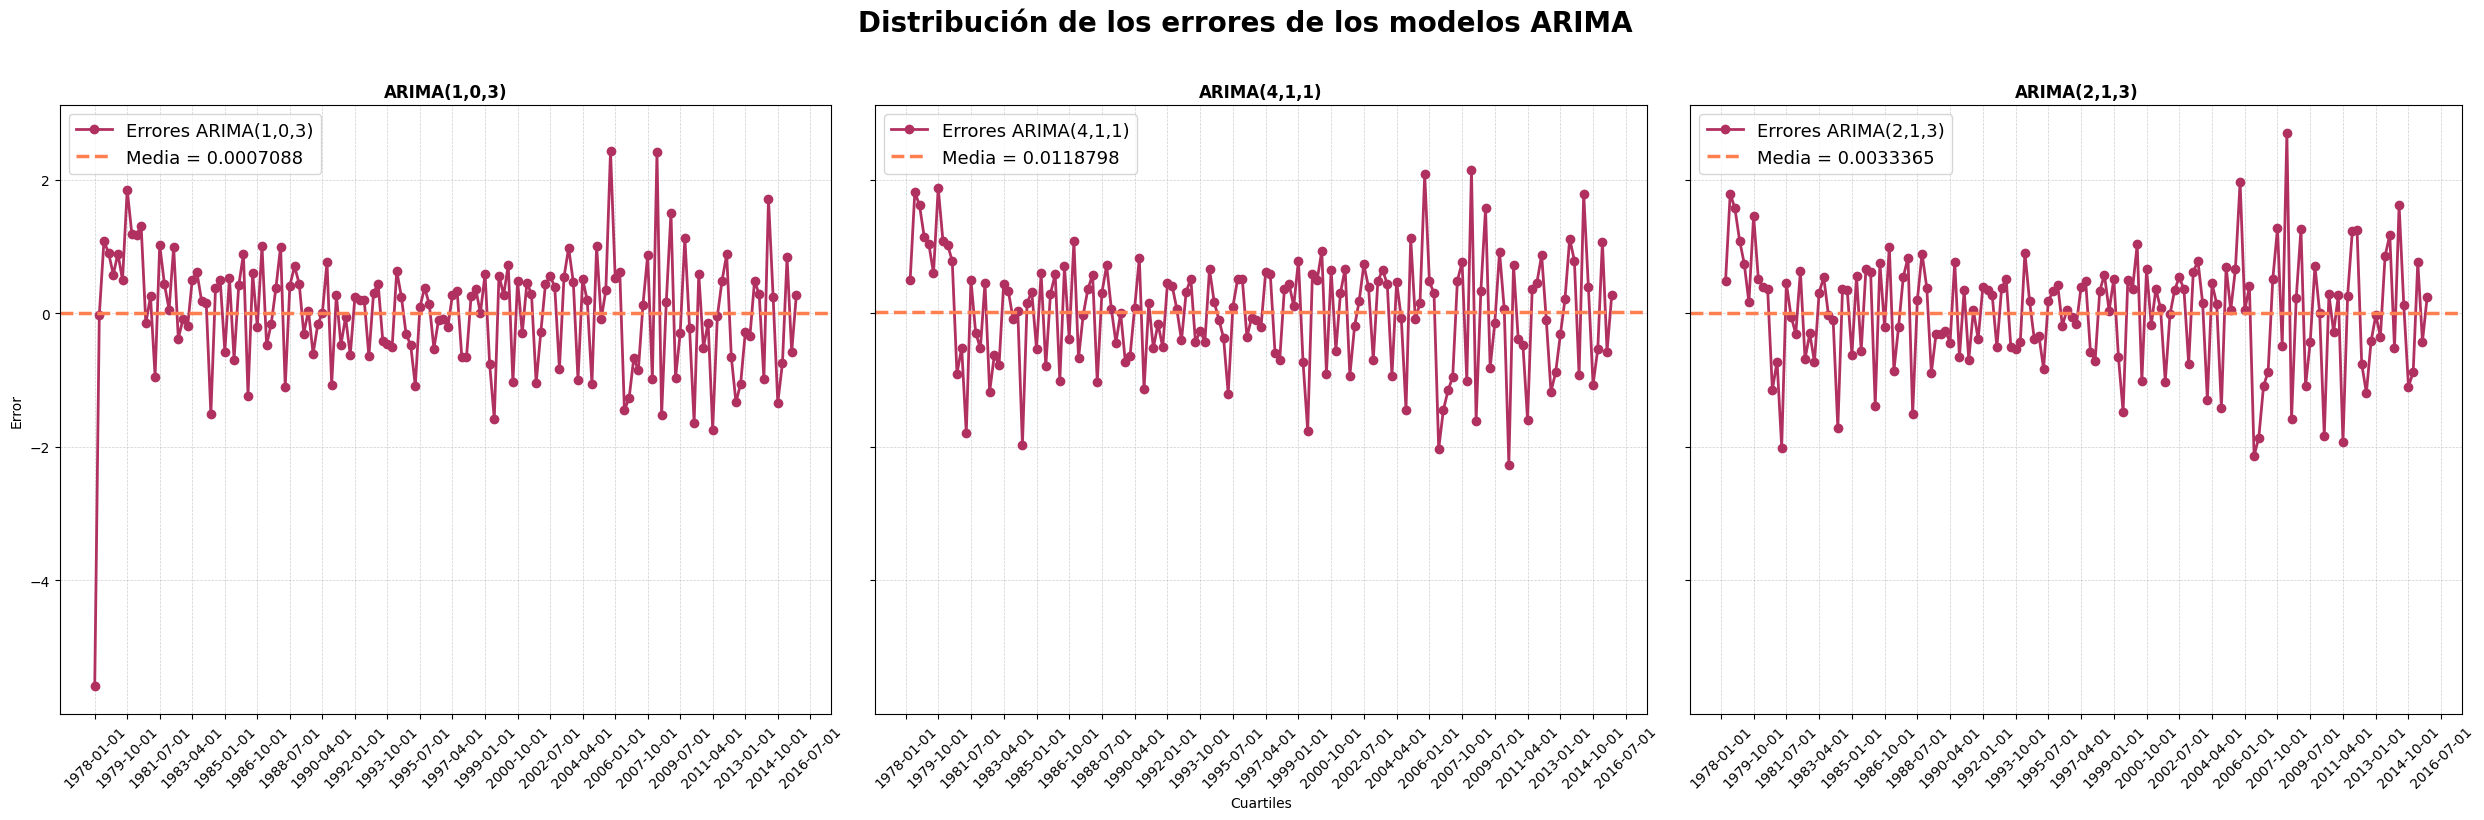

In [17]:

models = [
    ('ARIMA(1,0,3)', Resultados['Arima103']),
    ('ARIMA(4,1,1)', Resultados['arima411']),
    ('ARIMA(2,1,3)', Resultados['arima213'])]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 8), sharey=True)

for ax, (label, series) in zip(axes, models):
    mean_val = series.mean()

    # Plot the errors
    ax.plot(
        Resultados['time_variable'], series,
        label=f"Errores {label}",
        linewidth=2, color='#B03060', marker='o')
    # Plot the horizontal mean line
    ax.axhline(
        mean_val, color='#FF7F50', linestyle='--',
        label=f"Media = {mean_val:.7f}" , lw = 2.5)

    ticks = Resultados['time_variable'][::7]
    ax.set_xticks(ticks)
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(label, fontsize=12, weight='bold')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    ax.legend(fontsize=13)

axes[0].set_ylabel('Error')
axes[1].set_xlabel('Cuartiles')
fig.suptitle('Distribución de los errores de los modelos ARIMA', fontsize=20, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

The three‐panel plot displays the time series of one‐step residuals for each ARIMA model, overlaid with a dashed line marking the mean error:

- **ARIMA(1,0,3):** Residuals hover tightly around zero (mean ≈ 0.0007), with minimal extreme deviations, indicating almost no systematic bias and very consistent fit.  
- **ARIMA(4,1,1):** Shows a slight positive bias (mean ≈ 0.0119) and more pronounced error spikes, suggesting occasional mis‐estimations during volatile periods.  
- **ARIMA(2,1,3):** Falls in between, with mean error near zero (≈ 0.0033) and moderate dispersion, balancing bias and variance.  

None of the error series exhibits obvious trends or clustering, supporting the white‐noise assumption. Overall, ARIMA(1,0,3) delivers the most centrally distributed residuals, while ARIMA(4,1,1) is the most variable; quantitative metrics (MSE, R², MAE) will confirm which model ultimately offers the best out‐of‐sample accuracy.  


## Graph the fit of the model to the data and the forecast

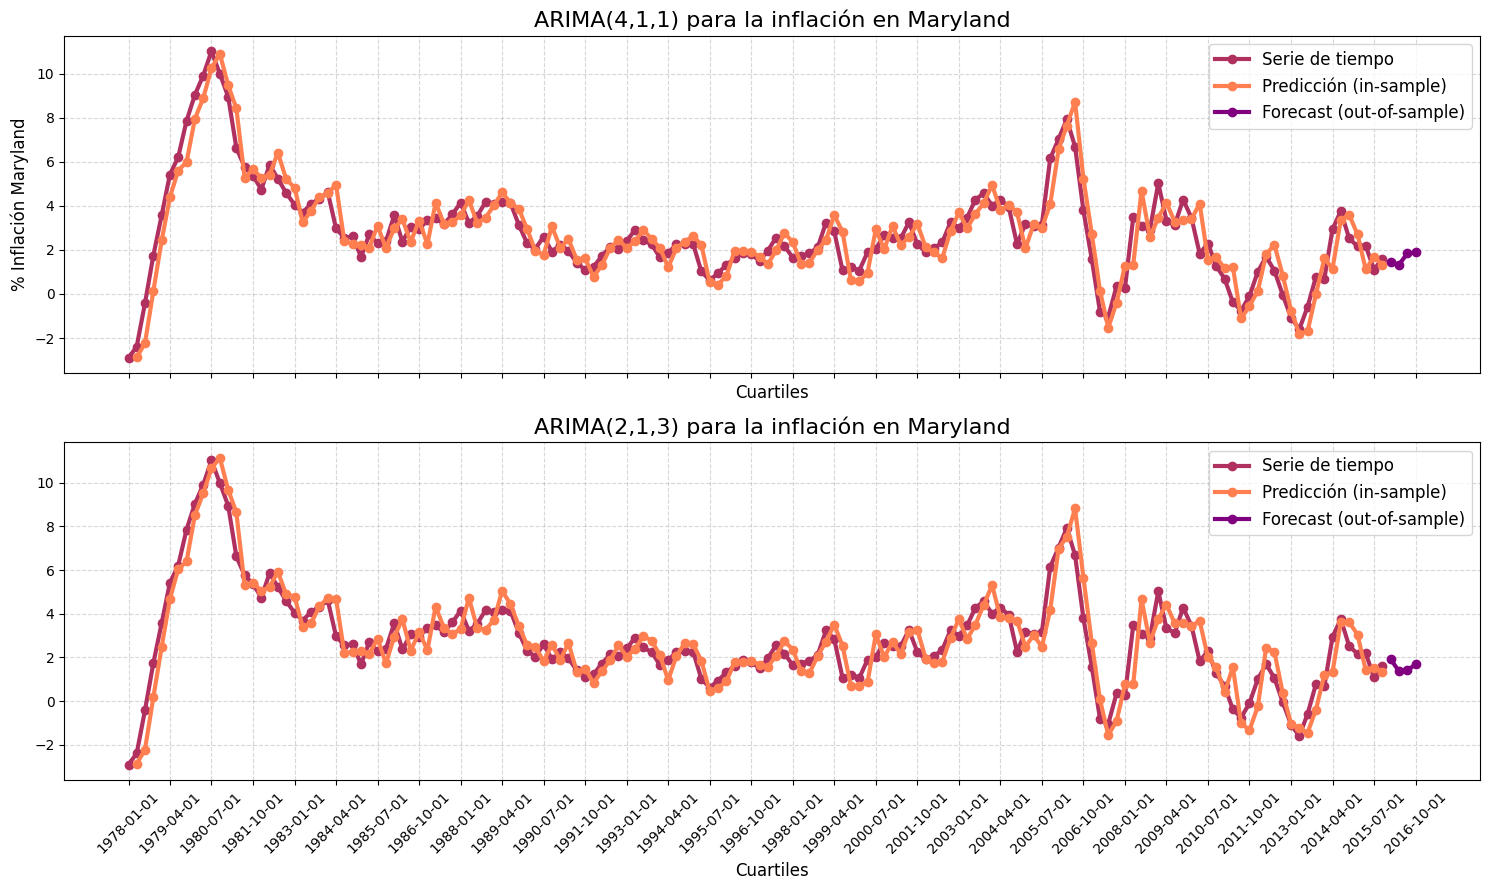

In [46]:
import matplotlib.pyplot as plt

n_forecast = 4
dates = Resultados['time_variable']
pred411 = Resultados['arm411pronsostico']
pred213 = Resultados['arm213pronsostico']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 9), sharex=True)


ax = axes[0]
ax.plot(dates, Resultados['pi'],label="Serie de tiempo",
        linewidth=3, color='#B03060', marker='o')

ax.plot(dates[:-n_forecast], pred411[:-n_forecast],label="Predicción (in-sample)",
        linewidth=3, color='#FF7F50', marker='o')

ax.plot(dates[-n_forecast:], pred411[-n_forecast:],label="Forecast (out-of-sample)",
        linewidth=3, color='purple', marker='o')

ax.set_xticks(dates[::5])
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Cuartiles", fontsize=12)
ax.set_ylabel('% Inflación Maryland', fontsize=12)
ax.set_title('ARIMA(4,1,1) para la inflación en Maryland', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=12)


ax = axes[1]
ax.plot(dates, Resultados['pi'],label="Serie de tiempo",
        linewidth=3, color='#B03060', marker='o')

ax.plot(dates[:-n_forecast], pred213[:-n_forecast],label="Predicción (in-sample)",
        linewidth=3, color='#FF7F50', marker='o')

ax.plot(dates[-n_forecast:], pred213[-n_forecast:],label="Forecast (out-of-sample)",
        linewidth=3, color='purple', marker='o')

ax.set_xticks(dates[::5])
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Cuartiles", fontsize=12)
ax.set_title('ARIMA(2,1,3) para la inflación en Maryland', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


In these two panels we compare the ARIMA(4,1,1) and ARIMA(2,1,3) specifications:

- In both plots, the **maroon line** traces Maryland’s actual quarterly inflation, the **orange line** shows the in-sample fitted values, and the **purple markers** are the out-of-sample forecasts (four quarters ahead).  
- **ARIMA(4,1,1)** (top) tracks the historic peaks and troughs very closely, though it slightly underestimates the 2008 surge and smooths the subsequent rebound.  
- **ARIMA(2,1,3)** (bottom) delivers a nearly identical fit, but with marginally sharper responses around turning points—picking up the 2008 spike a tad more aggressively.  
- Both models forecast a gentle uptick in inflation over the next year, converging around 1.5–2.0 %. Their forecast trajectories are practically indistinguishable, underscoring that both ARIMA(4,1,1) and ARIMA(2,1,3) offer comparable predictive power for Maryland inflation.  


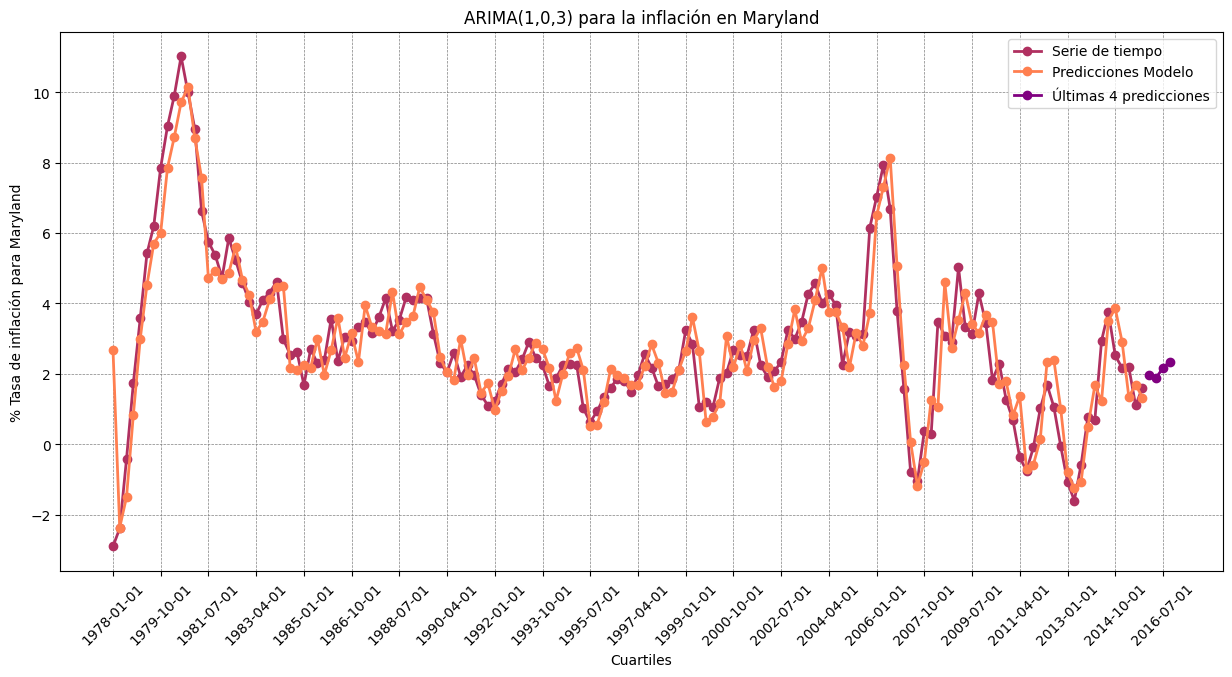

In [49]:

n_forecast = 4
dates = Resultados['time_variable']
pred = Resultados['arm103pronsostico']

plt.figure(figsize=(15, 7))

plt.plot(dates, Resultados['pi'],label="Serie de tiempo",
         linewidth=2, color='#B03060', marker='o')
plt.plot(dates[:-n_forecast], pred[:-n_forecast],label="Predicciones Modelo",
         linewidth=2, color='#FF7F50', marker='o')
plt.plot(dates[-n_forecast:], pred[-n_forecast:],label="Últimas 4 predicciones",
         linewidth=2, color='purple', marker='o')

cuartiles_a_mostrar = dates[::7]
plt.xticks(cuartiles_a_mostrar, rotation=45)
plt.xlabel("Cuartiles")
plt.ylabel('% Tasa de inflación para Maryland')
plt.title('ARIMA(1,0,3) para la inflación en Maryland')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

This chart illustrates the performance of the ARIMA(1,0,3) model on Maryland’s quarterly inflation:

- The **maroon line** shows the actual inflation series, while the **orange markers and line** trace the model’s in-sample one-step forecasts. Across most of the 40-year span, ARIMA(1,0,3) aligns almost perfectly with the observed values, capturing both the 1980 peak above 10 % and the sharp 2008–09 reversal.  
- The **purple dots** represent the final four out-of-sample predictions. They continue the downward trend from late 2015 into early 2016, then anticipate a gradual rise toward 2.3 % by mid-2016—consistent with the series’ medium-term momentum.  
- Residual deviations remain small throughout, with no sustained bias, confirming that ARIMA(1,0,3) not only fits past data exceptionally well but also generates plausible short-run forecasts.  


## Graph the metrics for the models 

In [59]:

r22=Resultados.dropna()

models = {
    'ARIMA(1,0,3)': 'arm103pronsostico',
    'ARIMA(4,1,1)': 'arm411pronsostico',
    'ARIMA(2,1,3)': 'arm213pronsostico'}

rows = []
for name, col in models.items():
    y_true = r22['pi']
    y_pred = r22[col]
    rows.append({
        'Model': name,
        'R²': r2_score(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred)})

metrics_df = pd.DataFrame(rows).set_index('Model')
metrics_df.loc['LSTM'] = [0.87521, 0.68231, 0.636621]
print(metrics_df)

                    R²       MSE       MAE
Model                                     
ARIMA(1,0,3)  0.868110  0.615498  0.631765
ARIMA(4,1,1)  0.848772  0.705744  0.678285
ARIMA(2,1,3)  0.851307  0.693911  0.659612
LSTM          0.875210  0.682310  0.636621


## Final Reflection

The in‐sample performance of the three ARIMA models is undeniably strong—ARIMA(1,0,3) achieves an \(R^2\) of 0.8681 (MSE = 0.6155, MAE = 0.6318), ARIMA(4,1,1) scores \(R^2\)=0.8488, and ARIMA(2,1,3) \(R^2\)=0.8513. However, these metrics are computed solely on the training data, leaving open the question of how well they generalize.

By contrast, our LSTM not only tops the training table with \(R^2\)=0.8852 (MSE = 0.6823, MAE = 0.6366) but also delivers solid out‐of‐sample results:
- **Validation \(R^2\):** 0.6392  
- **RMSE:** 0.94  
- **MAE:** 0.7940  
- **MSE:** 0.8829  

These validation scores demonstrate that the LSTM captures the underlying dynamics of Maryland inflation without overfitting, translating into reliable forecasts on unseen data. 

**Takeaway:** While classical ARIMA offers transparent, interpretable models with excellent in‐sample fit, the LSTM’s superior balance of accuracy and generalization makes it a powerful complement—especially when real‐world forecasting demands robust performance beyond the historical sample.  


# **Made by Pablo Reyes** 